In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import os
from dotenv import load_dotenv
import time
import re


In [ ]:
def read_data():
    load_dotenv()
    API_key = os.getenv('ALPHAVANTAGE_API_KEY')

    symbols = ["AAPL", "MSFT", "SPY", "TSLA", "GOOGL", "AMZN", "META"]

    base_url = "https://www.alphavantage.co/query"

    all_data = []  # List to store each symbol's data

    for symbol in symbols:
        print(f"Downloading weekly data for {symbol}...")

        params = {
            "function": "TIME_SERIES_WEEKLY_ADJUSTED",
            "symbol": symbol,
            "apikey": API_key
        }

        for attempt in range(3):
            r = requests.get(base_url, params=params)
            try:
                data = r.json()
                break
            except ValueError:
                print(f"Invalid response for {symbol}, attempt {attempt+1}")
                print("Raw response:", r.text[:200])
                time.sleep(15)
        else:
            print(f"Failed to get valid JSON for {symbol}, skipping...")
            continue

        if "Weekly Adjusted Time Series" not in data:
            print(f"Error for {symbol}: {data}")
            time.sleep(15)
            continue

        df = pd.DataFrame(data["Weekly Adjusted Time Series"]).T

        # Keep default integer index, create new column 'Date'
        df['Date'] = pd.to_datetime(df.index)

        # Sort by Date if needed
        df = df.sort_values('Date')

        df = df[df['Date'].between(pd.Timestamp("2015-12-04"), pd.Timestamp("2020-12-04"))]

        df['Symbol'] = symbol
        df.reset_index(drop=True, inplace=True)  # Drop old string index

        all_data.append(df)
        time.sleep(15)
    return df


In [ ]:
def combine_data():
    df1 = pd.read_csv("weekly_5yr_all_symbols.csv")
    df2 = pd.read_csv("weekly_5yr_all_symbols_pt_2.csv")

    # Clean column names (remove leading numbers like "1. Price")
    df1.columns = [re.sub(r'^\d+\.\s*', '', col) for col in df1.columns]
    df2.columns = [re.sub(r'^\d+\.\s*', '', col) for col in df2.columns]

    # Reorder columns of df1
    df1 = df1[['Symbol', 'Date'] + [col for col in df1.columns if col not in ['Symbol', 'Date']]]

    # Reorder df2 the same way to guarantee matching column order
    df2 = df2[df1.columns]

    # Combine the two
    df = pd.concat([df1, df2], ignore_index=True)
    df = df.sort_values(['Symbol', 'Date']).reset_index(drop=True)

In [ ]:
def cleaning_pipeline(df):
    df = df.sort_values(['Symbol', 'Date']).reset_index(drop=True)

    # Clean column names (remove numbers like "1. open")
    df.columns = [re.sub(r'^\d+\.\s*', '', col) for col in df.columns]

    # Reorder columns
    df = df[['Symbol', 'Date'] + [col for col in df.columns if col not in ['Symbol', 'Date']]]
    df['close'] = df['close'].astype(float)

    # Sort by Symbol and Date to make sure diff works correctly
    df = df.sort_values(['Symbol', 'Date'])

    # Create a new column with difference from previous close
    df['Close_diff'] = df.groupby('Symbol')['close'].diff()
    
    #Percentage Change from Beginning
    df['Pct_Change'] = df.groupby('Symbol')['adjusted close'].transform(
        lambda x: (x / x.iloc[0] - 1) * 100
    )


In [39]:
def plot_closing_prices(df):
    df['Date'] = pd.to_datetime(df['Date'])
    symbols = df['Symbol'].unique()

    for sym in symbols:
        sub = df[df['Symbol'] == sym]

        plt.figure(figsize=(10,4))
        plt.plot(sub['Date'], sub['adjusted close'])
        plt.title(f"Closing Price Over Time: {sym}")
        plt.ylabel("Closing Price")
        plt.tight_layout()
        years = sorted(sub['Date'].dt.year.unique())
        tick_locs = [pd.Timestamp(f'{y}-01-01') for y in years]
        plt.xticks(ticks=tick_locs, labels=years, rotation=45)
        plt.show()

def plot_per_inc(df):
    df['Pct_Change'] = df.groupby('Symbol')['adjusted close'].transform(
    lambda x: (x / x.iloc[0] - 1) * 100
    )
    df['Date'] = pd.to_datetime(df['Date'])
    symbols = df['Symbol'].unique()

    for sym in symbols:
        sub = df[df['Symbol'] == sym]

        plt.figure(figsize=(10,4))
        plt.plot(sub['Date'], sub['Pct_Change'])
        plt.title(f"Closing Price Over Time: {sym}")
        plt.ylabel("Closing Price")
        plt.tight_layout()
        years = sorted(sub['Date'].dt.year.unique())
        tick_locs = [pd.Timestamp(f'{y}-01-01') for y in years]
        plt.xticks(ticks=tick_locs, labels=years, rotation=45)
        plt.show()

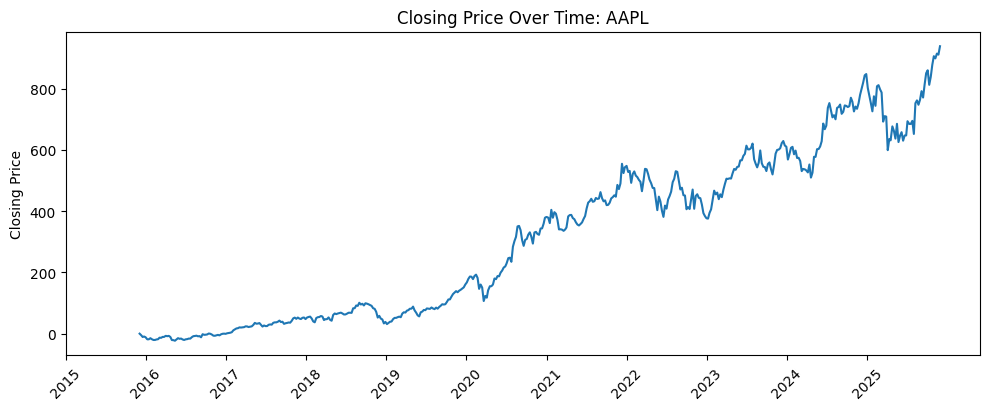

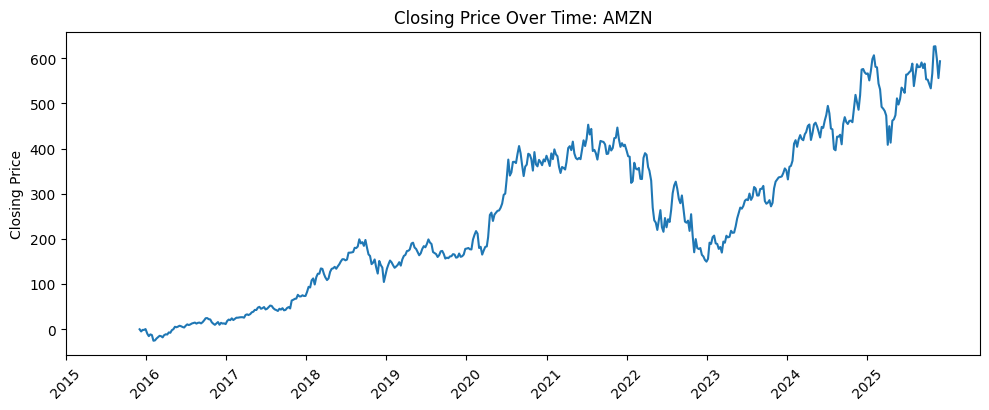

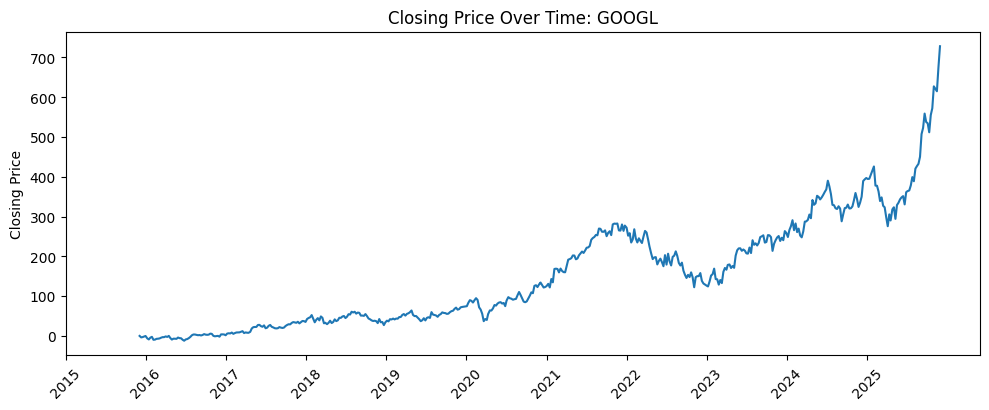

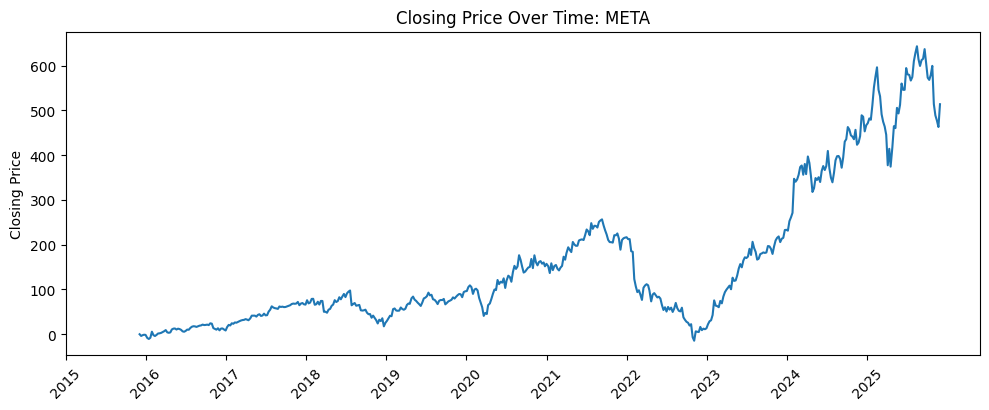

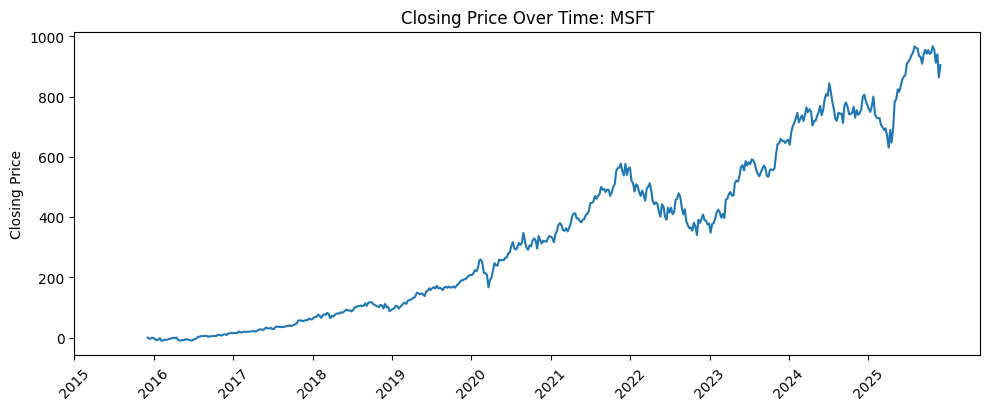

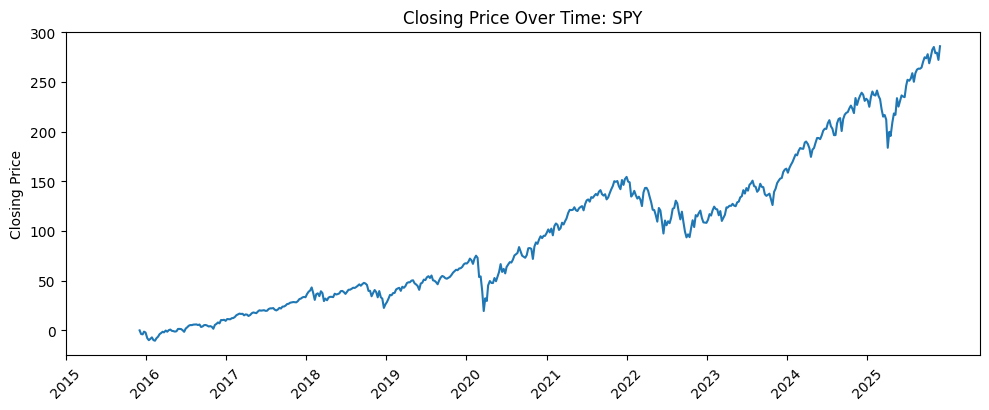

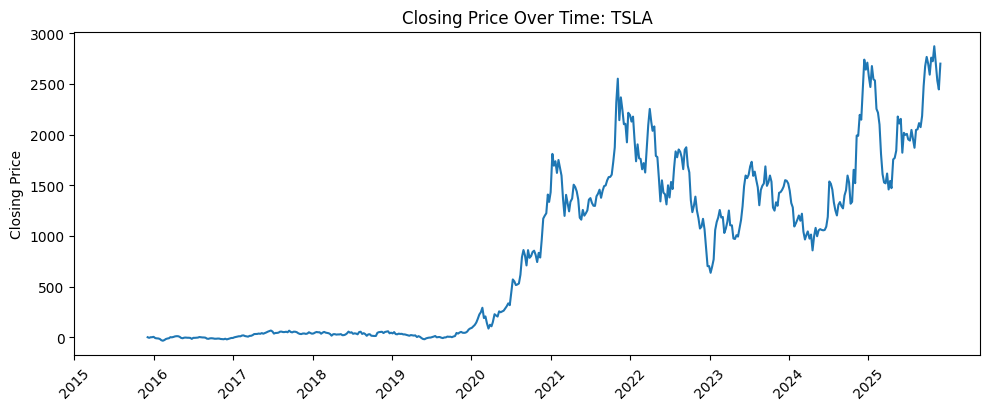

In [43]:
plot_per_inc(df)

In [ ]:
#We see that amazon, Tesla, and Google split had stocks suddenly decrease hinting they split their stocks
#Change data at the time of stock splits to account for the change




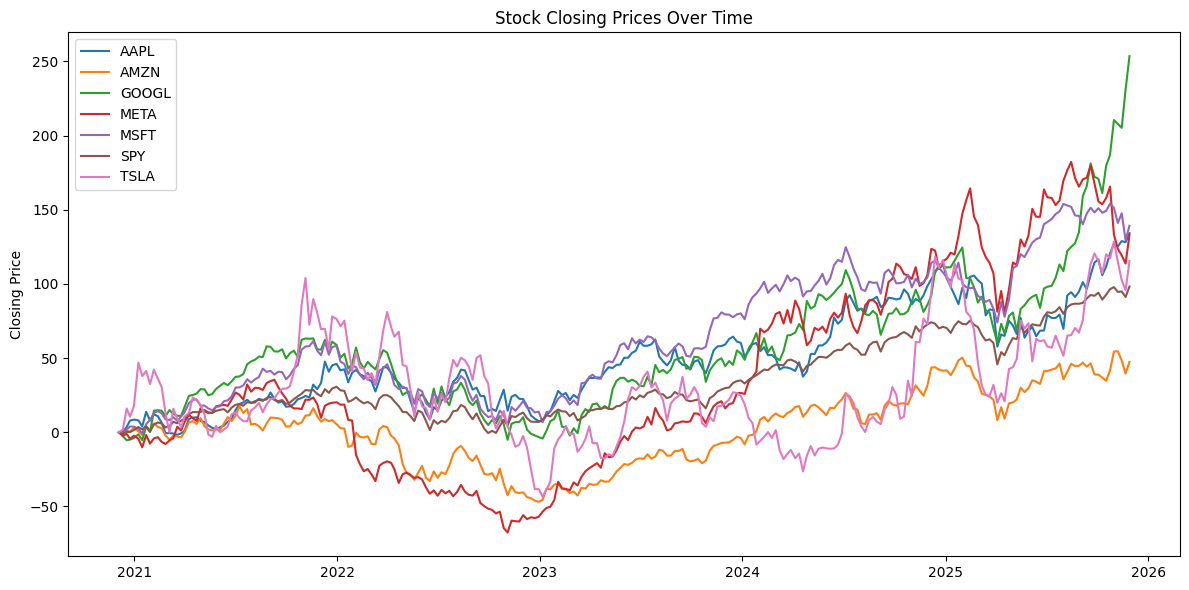

In [ ]:
def plot_all_stocks_together(df):
    plt.figure(figsize=(12,6))

    for sym in symbols:
        sub = df[df['Symbol'] == sym]
        plt.plot(sub['Date'], sub['Pct_Change'], label=sym)

    plt.title("Stock Closing Prices Over Time")
    plt.ylabel("Closing Price")
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_all_stocks_together(df)

In [23]:
#comparing each stock to the SPY
def compare_stocks(stock1, stock2, df):
    # Pull the data
    s1 = df[df['Symbol'] == stock1].copy()
    s2 = df[df['Symbol'] == stock2].copy()

    # Ensure sorted
    s1 = s1.sort_values("Date")
    s2 = s2.sort_values("Date")

    # -------------------------------
    # 1) Closing Price Over Time
    # -------------------------------
    plt.figure(figsize=(12,5))
    plt.plot(s1['Date'], s1['adjusted close'], label=stock1)
    plt.plot(s2['Date'], s2['adjusted close'], label=stock2)

    plt.title(f"{stock1} vs {stock2} — Closing Price Over Time")
    plt.xlabel("Year")
    plt.ylabel("Closing Price")

    # Year tick labels only
    years = sorted(df['Date'].dt.year.unique())
    ticks = [pd.Timestamp(f"{y}-01-01") for y in years]
    plt.xticks(ticks, years, rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.show()

    # -------------------------------
    # 2) Percentage Change Over Time
    # -------------------------------
    plt.figure(figsize=(12,5))
    plt.plot(s1['Date'], s1['Pct_Change'], label=stock1)
    plt.plot(s2['Date'], s2['Pct_Change'], label=stock2)

    plt.title(f"{stock1} vs {stock2} — Percentage Change Over Time")
    plt.xlabel("Year")
    plt.ylabel("Percentage Change")

    # Year tick labels only
    plt.xticks(ticks, years, rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.show()

In [29]:
#aggergate across all time and order stocks by which ones have performed best
performance = df.groupby('Symbol')['Pct_Change'].last().sort_values(ascending=False)
print("Stock Performance Over 5 Years:")
print(performance)

Stock Performance Over 5 Years:
Symbol
GOOGL    253.558777
MSFT     139.219887
AAPL     134.294064
META     133.074953
TSLA     115.429688
SPY       98.254902
AMZN      47.487178
Name: Pct_Change, dtype: float64


In [ ]:
# Volatility Analysis
volatility = df.groupby('Symbol')['Close_diff'].std().sort_values(ascending=False)
print("\nStock Volatility (Standard Deviation of Weekly Close Differences):")
print(volatility)


Stock Volatility (Standard Deviation of Weekly Close Differences):
Symbol
AMZN     162.167585
GOOGL    143.205635
TSLA      56.950281
META      20.343873
MSFT      11.069256
SPY       10.546683
AAPL       6.821088
Name: Close_diff, dtype: float64


In [ ]:
mean_close = df.groupby('Symbol')['Close_diff'].mean().sort_values(ascending=False)
print("\nMean Daily Weekly Difference:")
print(mean_close)


Mean Daily Close Difference:
Symbol
META      1.416346
SPY       1.205923
MSFT      1.067885
AAPL      0.602308
TSLA     -0.649500
GOOGL    -5.783000
AMZN    -11.266769
Name: Close_diff, dtype: float64
